* [Chapter 1 : Import Packages](#chapter1)
* [Chapter 2 : Data Exploration](#chapter2)
    * [Section 2.1 : Reading Files](#subchapter2.1)
    * [Section 2.2 : Pre-Processing](#subchapter2.2)
    * [Section 2.3 : Analyzing Count of Accomodation Type, Chain Hotel & Star Rating](#subchapter2.3)
    * [Section 2.4 : Time Series Analysis](#subchapter2.4)
* [Chapter 3 : Data Visualization](#chapter3)
    * [Section 3.1 : Checkin Day Frequency](#subchapter3.1)
    * [Section 3.2 : Relationship Between Mean Normalized ADR USD and Days Prior](#subchapter3.2)
    * [Section 3.3 : Correlation Matrix](#subchapter3.3)
* [Chapter 4 : Prediction](#chapter4)
    * [Section 4.1 : Defining Evaluation Metrics](#subchapter4.1)
    * [Section 4.2 : Linear Regression](#subchapter4.2)
    * [Section 4.3 : Decision Tree Regressor](#subchapter4.3)
    * [Section 4.4 : Lasso Regression](#subchapter4.4)
    * [Section 4.5 : Ridge Regression](#subchapter4.5)
    * [Section 4.6 : Elastic Net Regression](#subchapter4.6)
* [Chapter 5 : Conclustion](#chapter5)

# 1. IMPORT PACKAGES <a class="anchor"  id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# -Data Exploration <a class="anchor"  id="chapter2"></a>

\# - No of record in each dataset\
ADR – Average Daily Rate in US Dollars (Customer Total Amount / Room Nights)\
Hotel ID – Property identification number\
City ID – City identification number\
Star rating – Property’s star rating\
Accommodation Type Name – Property’s accommodation type\
Chain Hotel – Indicates whether the property is part of a chain or not\
Booking date – Date of booking made\
Check-in date – Date of check-in\
Check-out date – Date of check-out\

## --Reading the file <a class="anchor"  id="subchapter2.1"></a>

In [2]:
# Specify the file path of the Excel file
FILE = '/kaggle/input/hotel-booking/Case_Study_Urgency_Message_Data.xlsx'

# List of cities to process
CITIES = ['City_A', 'City_B', 'City_C', 'City_D', 'City_E']

# List to store individual hotel DataFrames
hotel_list = []

# Loop through each city
for CITY in CITIES:
    # Read the Excel sheet for the current city
    df = pd.read_excel(FILE, sheet_name=CITY)
    
    # Add a new column 'Table Name' to indicate the city
    df['Table Name'] = CITY
    
    # Append the DataFrame to the list
    hotel_list.append(df)

# Concatenate all individual hotel DataFrames into a single DataFrame
hotel_df = pd.concat(hotel_list, ignore_index=True)

# Save the concatenated DataFrame to an Excel file
hotel_df.to_excel('Hotel Analysis.xlsx', index=False)

# Display the concatenated DataFrame
display(hotel_df)

,#,ADR_USD,hotel_id,city_id,star_rating,accommodation_type_name,chain_hotel,booking_date,checkin_date,checkout_date,Table Name
0,1,71.060000,297388,9395,2.5,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,City_A
1,2,76.560000,298322,9395,3.0,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,City_A
2,3,153.880000,2313076,9395,5.0,Hotel,chain,2016-08-02,2016-10-01,2016-10-02,City_A
3,4,126.600000,2240838,9395,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,City_A
4,5,115.080000,2240838,9395,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,City_A
...,...,...,...,...,...,...,...,...,...,...,...
49059,4813,72.580000,130890,8584,4.0,Hotel,non-chain,2016-12-31,2016-12-31,2017-01-02,City_E
49060,4814,70.020000,130890,8584,4.0,Hotel,non-chain,2016-12-31,2016-12-31,2017-01-01,City_E
49061,4815,921.260000,21720,8584,5.0,Resort,non-chain,2016-12-31,2016-12-31,2017-01-01,City_E
49062,4816,345.086667,21720,8584,5.0,Resort,non-chain,2016-12-31,2016-12-31,2017-01-03,City_E


## --Preprocessing <a class="anchor"  id="subchapter2.2"></a>

In [3]:
# Define a function to calculate the number of days prior to check-in date
def calculate_days_prior(booking_date, checkin_date):
    days_prior = (checkin_date - booking_date).days
    return days_prior

# Define functions to get the day of the week for booking and check-in dates
def get_booking_day(booking_date):
    return booking_date.day_name()

def get_checkin_day(checkin_date):
    return checkin_date.day_name()

def get_booking_day_of_year(booking_date):
    return booking_date.day_of_year

def get_checkin_day_of_year(checkin_date):
    return checkin_date.day_of_year

# Constant for the number of top records to consider
TOP = 5

# Calculate days prior and get booking/check-in days
hotel_df['days_prior'] = hotel_df.apply(lambda x: calculate_days_prior(x['booking_date'], x['checkin_date']), axis=1)
hotel_df['booking_day'] = hotel_df.apply(lambda x: get_booking_day(x['booking_date']), axis=1)
hotel_df['checkin_day'] = hotel_df.apply(lambda x: get_checkin_day(x['checkin_date']), axis=1)
hotel_df['booking_day_of_year'] = hotel_df.apply(lambda x: get_booking_day_of_year(x['booking_date']), axis=1)
hotel_df['checkin_day_of_year'] = hotel_df.apply(lambda x: get_checkin_day_of_year(x['checkin_date']), axis=1)

# Calculate the mean ADR_USD for each star rating and hotel
mean_df = hotel_df.groupby(['star_rating', 'hotel_id'])['ADR_USD'].mean().reset_index()

# Merge the mean ADR_USD back into the original dataframe
merged_df = pd.merge(hotel_df, mean_df, on=['hotel_id', 'star_rating'])

# Calculate normalized_ADR_USD using the mean ADR_USD
merged_df['normalized_ADR_USD'] = (merged_df['ADR_USD_x'] - merged_df['ADR_USD_y']) / merged_df['ADR_USD_y']

# Display the first few rows of the merged DataFrame
display(merged_df.head())

,#,ADR_USD_x,hotel_id,city_id,star_rating,accommodation_type_name,chain_hotel,booking_date,checkin_date,checkout_date,Table Name,days_prior,booking_day,checkin_day,booking_day_of_year,checkin_day_of_year,ADR_USD_y,normalized_ADR_USD
0,1,71.06,297388,9395,2.5,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,City_A,60,Tuesday,Saturday,215,275,73.754139,-0.036529
1,27,58.62,297388,9395,2.5,Hotel,non-chain,2016-08-09,2016-10-01,2016-10-04,City_A,53,Tuesday,Saturday,222,275,73.754139,-0.205197
2,39,78.92,297388,9395,2.5,Hotel,non-chain,2016-08-10,2016-10-04,2016-10-06,City_A,55,Wednesday,Tuesday,223,278,73.754139,0.070042
3,42,75.42,297388,9395,2.5,Hotel,non-chain,2016-08-10,2016-10-09,2016-10-12,City_A,60,Wednesday,Sunday,223,283,73.754139,0.022587
4,45,78.92,297388,9395,2.5,Hotel,non-chain,2016-08-10,2016-10-05,2016-10-06,City_A,56,Wednesday,Wednesday,223,279,73.754139,0.070042


In [4]:
# Calculate the mean normalized_ADR_USD for each category (combination of 'hotel_id' and 'Table Name')
category_means = merged_df.groupby(['hotel_id', 'Table Name'])['normalized_ADR_USD'].mean()

# Get the top hotels for each category
top_hotels_per_category = category_means.groupby('Table Name', group_keys=False).apply(lambda x: x.nlargest(TOP))

# Convert the top hotels from the result to a list
top_hotel_list = top_hotels_per_category.reset_index()['hotel_id'].values.tolist()

# Filter the merged_df to include only the top hotels
top_hotel_df = merged_df[merged_df['hotel_id'].isin(top_hotel_list)]

# Print the list of top hotel IDs
print(top_hotel_list)

# Display the DataFrame containing the top hotels
display(top_hotel_df)


[534374, 525626, 323518, 373272, 586114, 583938, 599270, 1636646, 1071000, 323444, 2749370, 200300, 2541182, 2621064, 3205146, 1565182, 1250212, 1841224, 2120220, 1093074, 2428930, 611840, 298160, 575340, 2710530]


,#,ADR_USD_x,hotel_id,city_id,star_rating,accommodation_type_name,chain_hotel,booking_date,checkin_date,checkout_date,Table Name,days_prior,booking_day,checkin_day,booking_day_of_year,checkin_day_of_year,ADR_USD_y,normalized_ADR_USD
6190,24,365.60,525626,9395,5.0,Hotel,chain,2016-08-09,2016-10-07,2016-10-08,City_A,59,Tuesday,Friday,222,281,307.226497,0.190002
6191,25,365.60,525626,9395,5.0,Hotel,chain,2016-08-09,2016-10-08,2016-10-09,City_A,60,Tuesday,Saturday,222,282,307.226497,0.190002
6192,52,266.06,525626,9395,5.0,Hotel,chain,2016-08-11,2016-10-05,2016-10-06,City_A,55,Thursday,Wednesday,224,279,307.226497,-0.133994
6193,604,293.88,525626,9395,5.0,Hotel,chain,2016-09-07,2016-10-06,2016-10-07,City_A,29,Wednesday,Thursday,251,280,307.226497,-0.043442
6194,855,289.92,525626,9395,5.0,Hotel,chain,2016-09-13,2016-10-07,2016-10-08,City_A,24,Tuesday,Friday,257,281,307.226497,-0.056331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48947,3654,48.36,2710530,8584,3.0,Hotel,non-chain,2016-12-02,2016-12-23,2016-12-25,City_E,21,Friday,Friday,337,358,61.890000,-0.218614
48948,3715,116.47,2710530,8584,3.0,Hotel,non-chain,2016-12-03,2016-12-10,2016-12-12,City_E,7,Saturday,Saturday,338,345,61.890000,0.881887
48949,3888,49.52,2710530,8584,3.0,Hotel,non-chain,2016-12-07,2016-12-10,2016-12-11,City_E,3,Wednesday,Saturday,342,345,61.890000,-0.199871
48950,3900,49.52,2710530,8584,3.0,Hotel,non-chain,2016-12-07,2016-12-11,2016-12-12,City_E,4,Wednesday,Sunday,342,346,61.890000,-0.199871


In [5]:
CATEGORICAL_COLS = ['accommodation_type_name', 'chain_hotel', 'checkin_day', 'booking_day']
NUMERICAL_COLS = ['star_rating', 'days_prior', 'ADR_USD']

### ---County of Accomodation Type, Chain Hotel, Star Rating <a class="anchor"  id="subchapter2.3"></a>

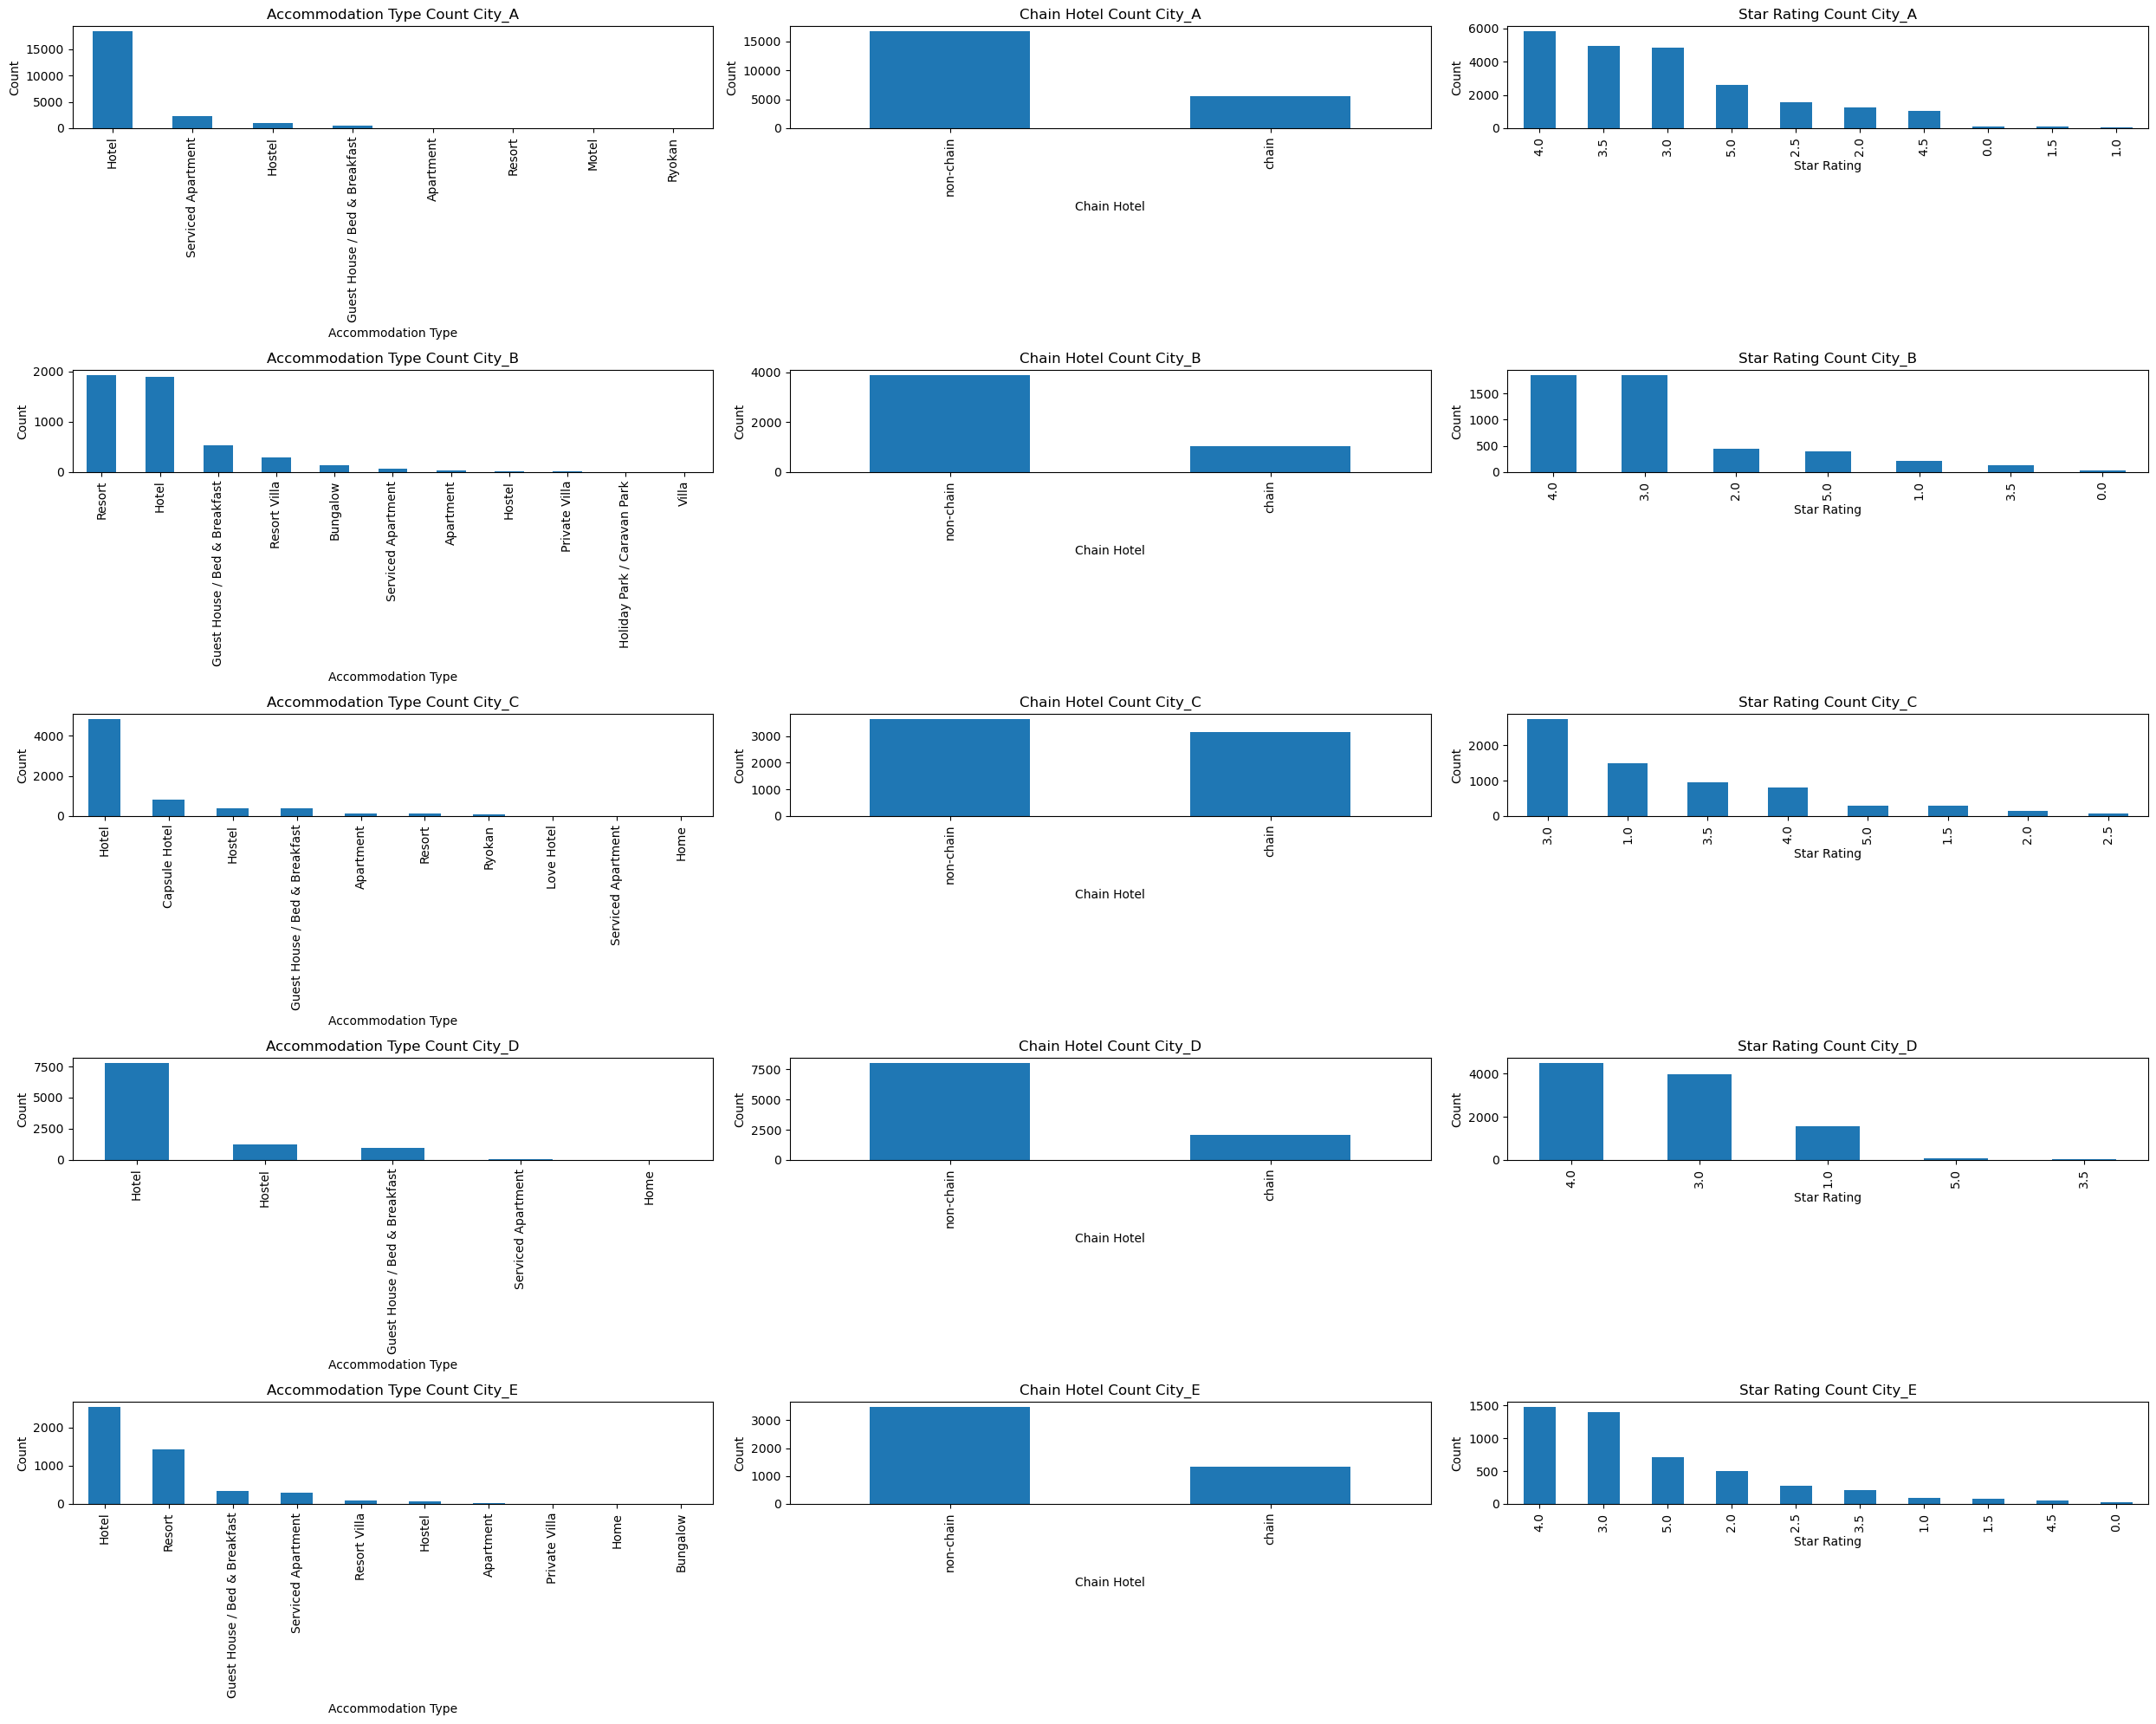

In [6]:
# Creating a subplot with 5 rows and 3 cols
fig, axes = plt.subplots(5, 3, figsize=(25, 20))

for idx, CITY in enumerate(CITIES):    
    col_idx = idx // 5  # Calculate the row index for the subplot
    row_idx = idx % 5   # Calculate the column index for the subplot
    ax = axes[row_idx, col_idx]
    
    # Plot 1: Accommodation Type Count
    accommodation_counts = merged_df[merged_df['Table Name'] == CITY]['accommodation_type_name'].value_counts()
    accommodation_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Accommodation Type Count {CITY}')
    ax.set_xlabel('Accommodation Type')
    ax.set_ylabel('Count')

    ax1 = axes[row_idx, col_idx+1]
    # Plot 2 : Chain Hotel Count
    chain_counts = merged_df[merged_df['Table Name'] == CITY]['chain_hotel'].value_counts()
    chain_counts.plot(kind='bar', ax=ax1)
    ax1.set_title(f'Chain Hotel Count {CITY}')
    ax1.set_xlabel('Chain Hotel')
    ax1.set_ylabel('Count')
    
    ax2 = axes[row_idx, col_idx+2]
    # Plot 3 : Star Rating Count
    star_counts = merged_df[merged_df['Table Name'] == CITY]['star_rating'].value_counts()
    star_counts.plot(kind='bar', ax=ax2)
    ax2.set_title(f'Star Rating Count {CITY}')
    ax2.set_xlabel('Star Rating')
    ax2.set_ylabel('Count')    
 
plt.tight_layout()
plt.show()

### ---Time Series Analysis <a class="anchor"  id="subchapter2.4"></a>

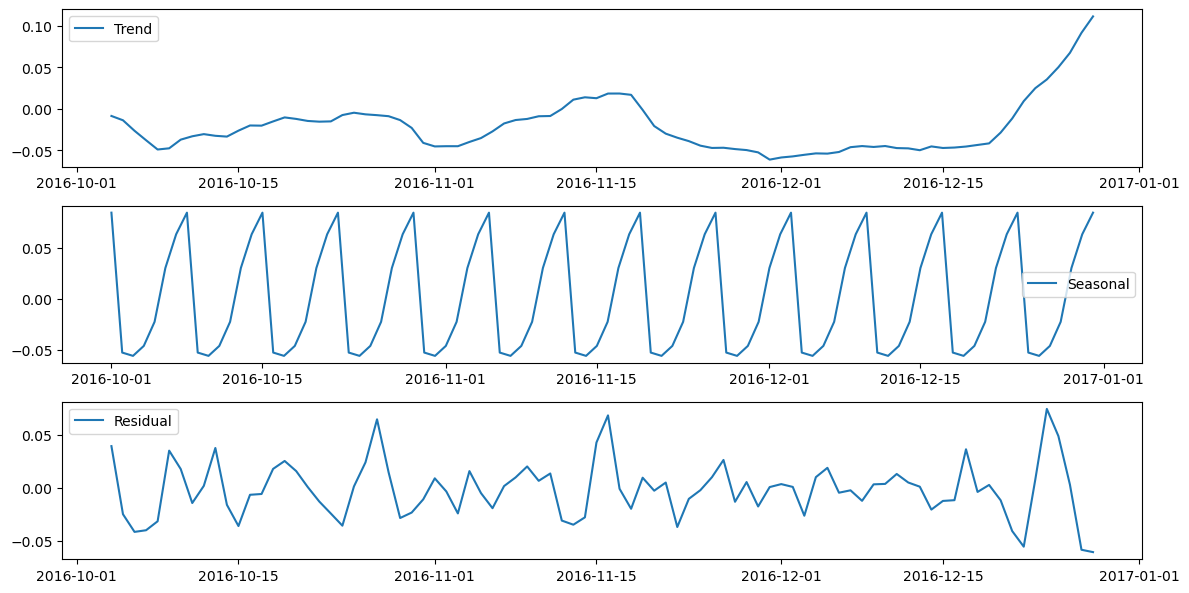

In [7]:
# Set the date column as the index
merged_checkin_date_df = merged_df.groupby('checkin_date')['normalized_ADR_USD'].mean()
merged_checkin_date_df = merged_checkin_date_df.asfreq('D')

# Perform time series analysis
decomposition = sm.tsa.seasonal_decompose(merged_checkin_date_df, model='additive')

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

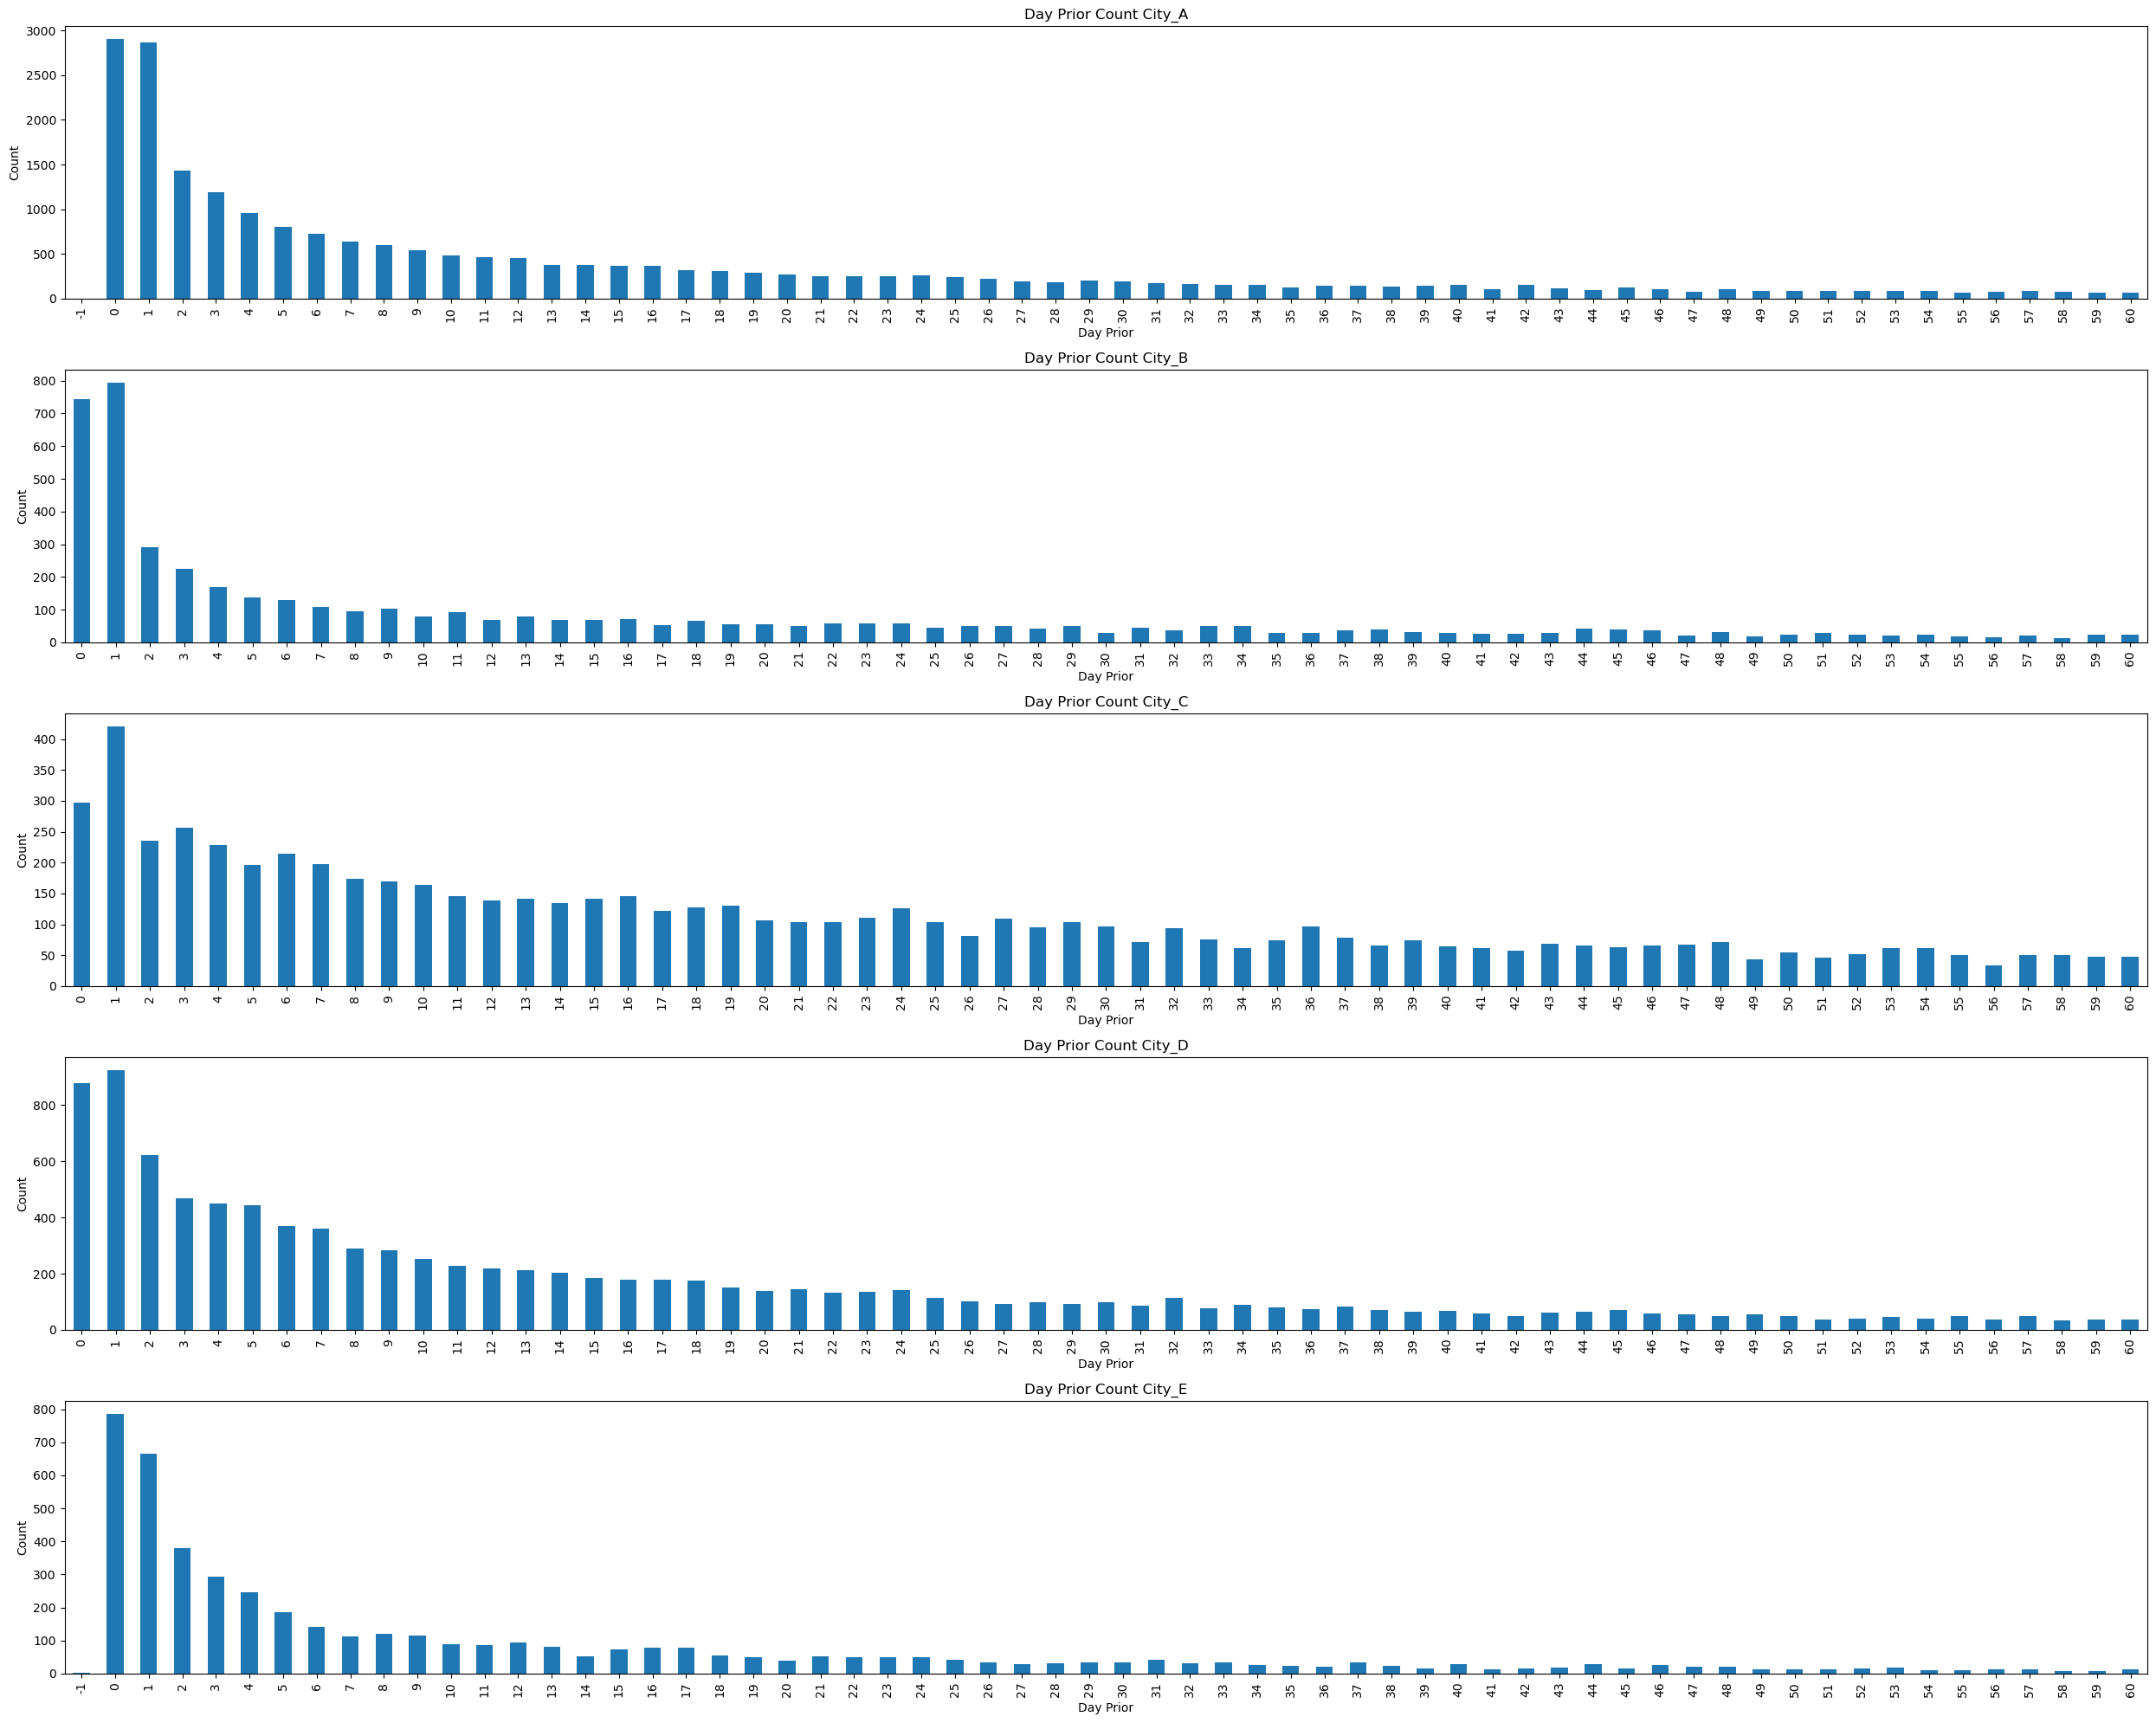

In [8]:
# Create a subplot with 5 rows and 1 col
fig, axes = plt.subplots(5, 1, figsize=(25, 20))

for idx, CITY in enumerate(CITIES):    
    ax = axes[idx]
    
    # Plot 4 : Day Prior Count
    day_prior_counts = merged_df[merged_df['Table Name'] == CITY]['days_prior'].value_counts().sort_index()
    day_prior_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Day Prior Count {CITY}')
    ax.set_xlabel('Day Prior')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

# -Data Visualization <a class="anchor"  id="chapter3"></a>

## --Checkin Days Frequency <a class="anchor"  id="subchapter3.1"></a>

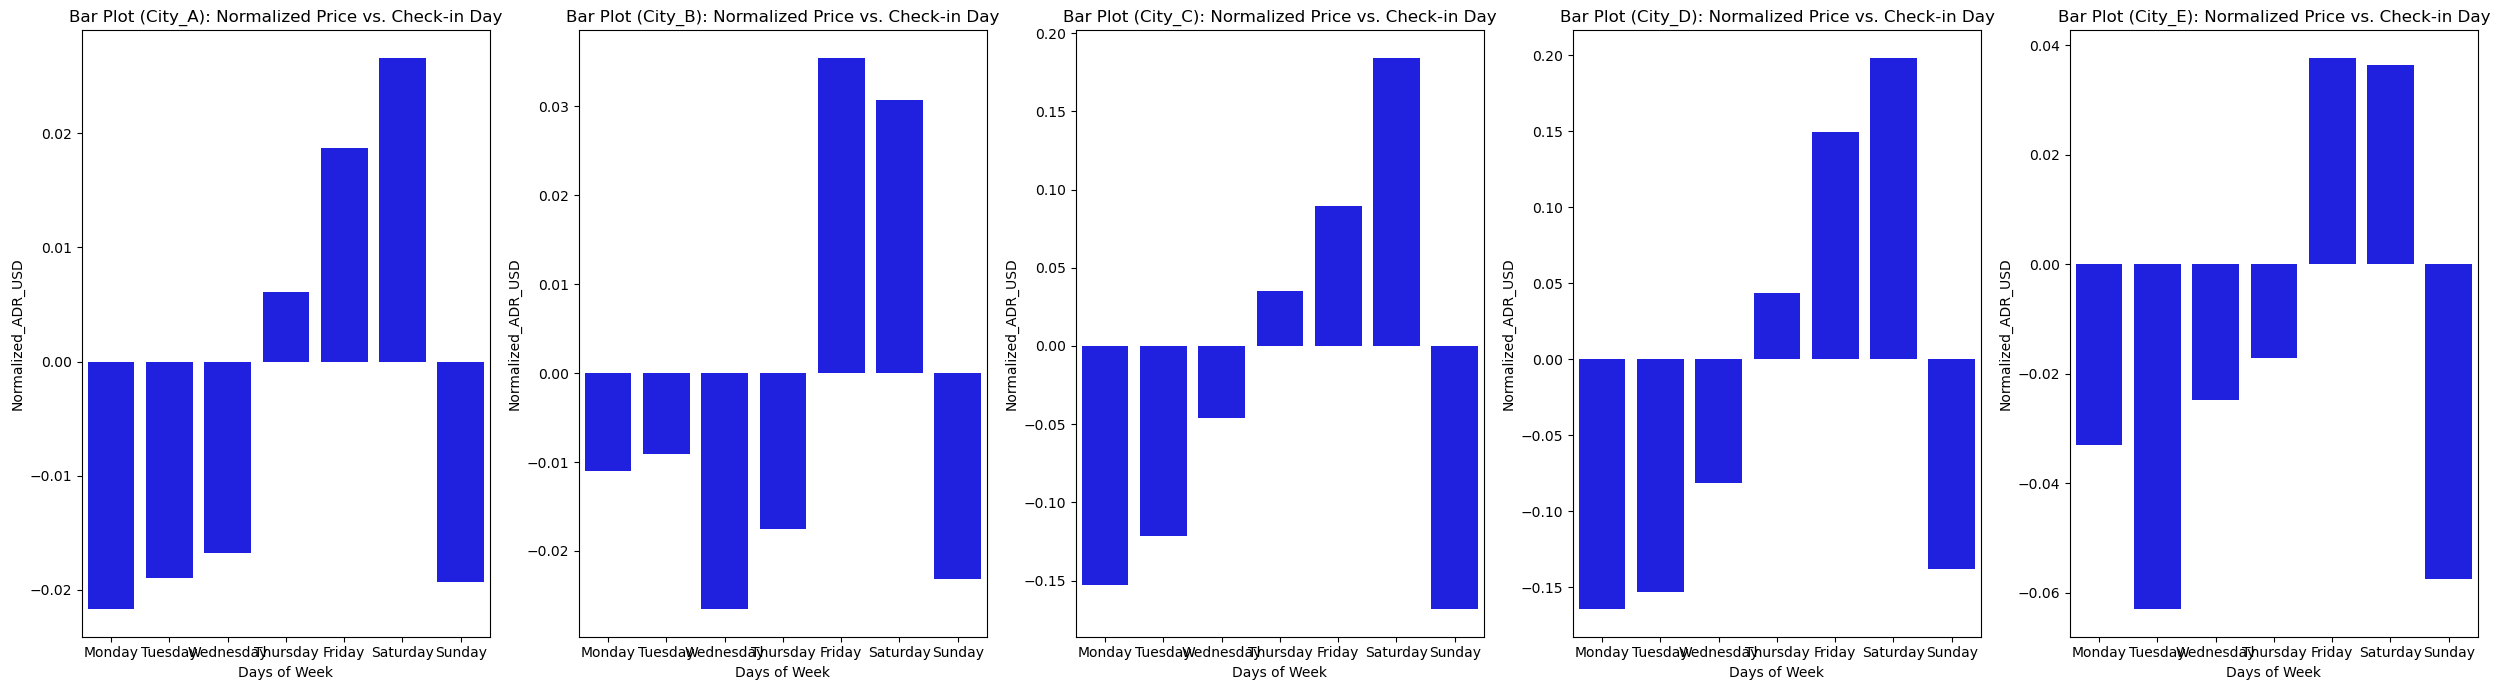

In [9]:
# List of days of the week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create subplots for each city
fig, axes = plt.subplots(1, 5, figsize=(25, 7))

# Group the data by 'Table Name' and 'checkin_day' and calculate the mean of 'normalized_ADR_USD'
grouped_by_checkin_day = merged_df.groupby(['Table Name', 'checkin_day'])['normalized_ADR_USD'].mean().reset_index()

# Loop through each city and plot the box plots
for idx, CITY in enumerate(CITIES):
    # Filter the data for the current city
    grouped_by_checkin_day1 = grouped_by_checkin_day[grouped_by_checkin_day['Table Name'] == CITY]
    grouped_by_checkin_day1 = grouped_by_checkin_day1.set_index('checkin_day').reindex(cats).reset_index()
    
    ax = axes[idx]  # Get the specific subplot for the current city

    # Plot the bar chart using Seaborn
    sns.barplot(data=grouped_by_checkin_day1, x='checkin_day',
                y='normalized_ADR_USD', ax=ax, color='blue')
    ax.set_xlabel('Days of Week')
    ax.set_ylabel('Normalized_ADR_USD')
    ax.set_title(f'Bar Plot ({CITY}): Normalized Price vs. Check-in Day')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## --Relationship between Mean Normalized ADR USD and Days Prior <a class="anchor"  id="subchapter3.2"></a>

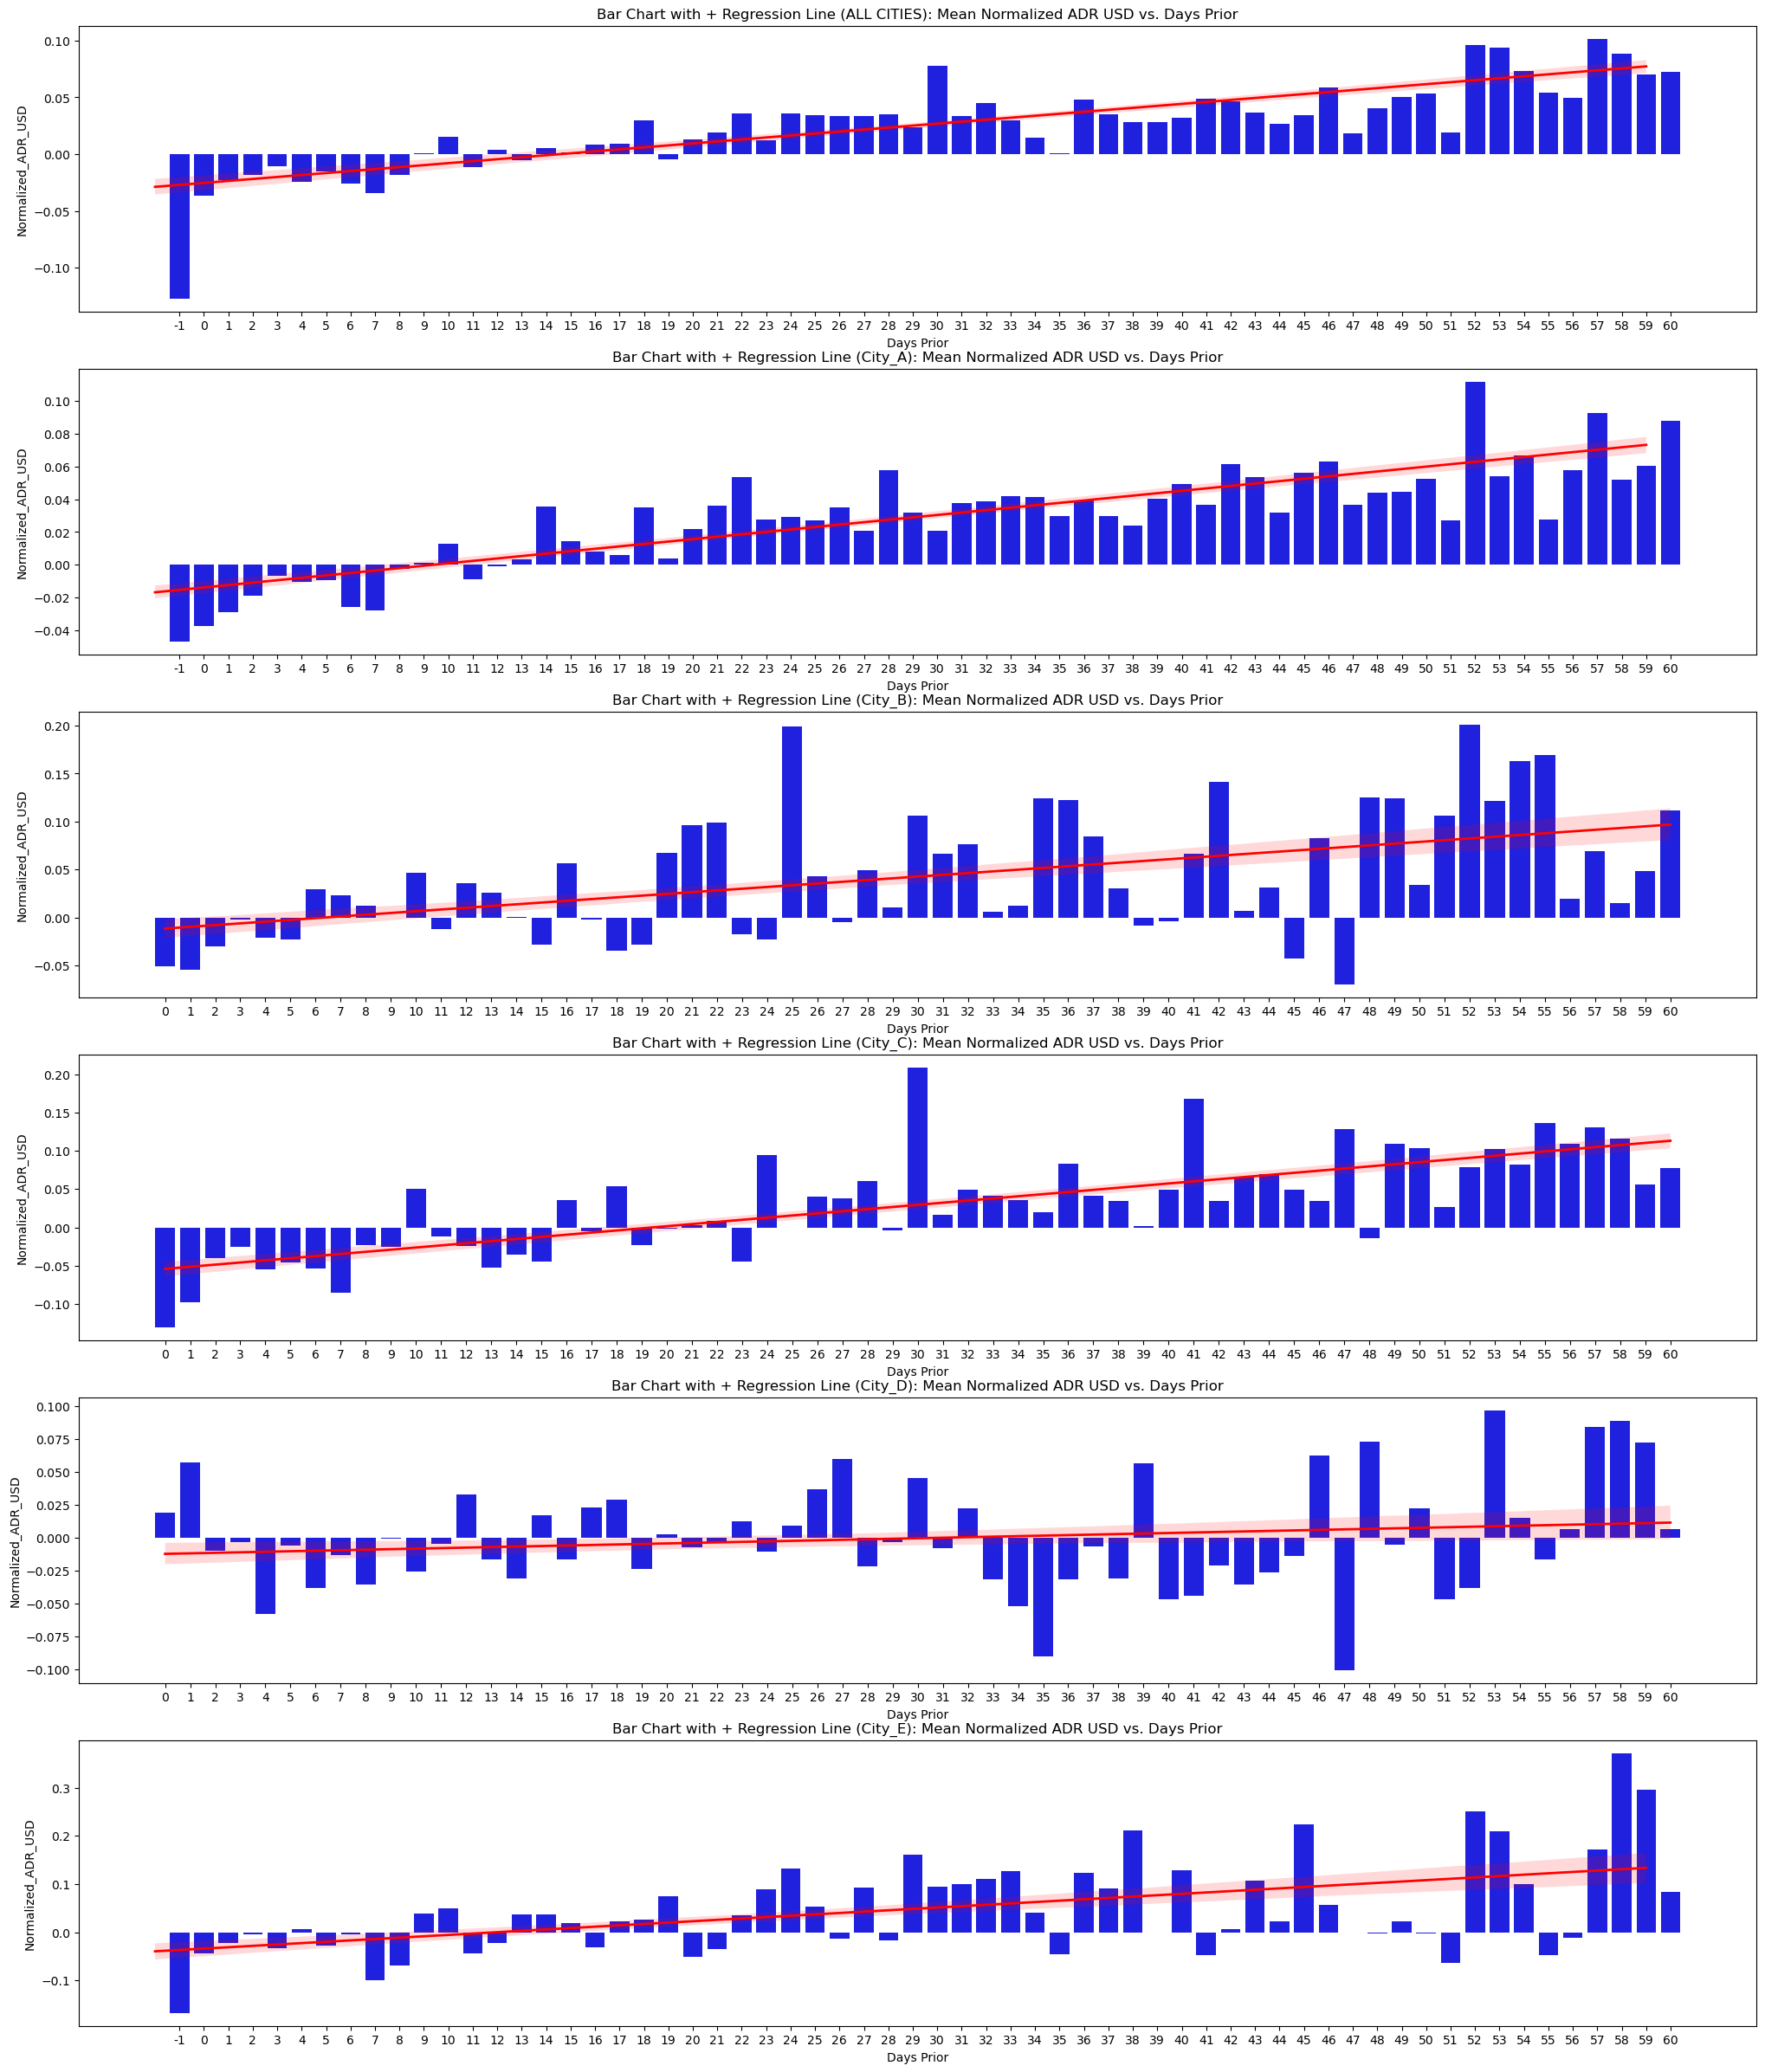

In [10]:
# Group the data by 'days_prior' and calculate the mean of 'normalized_ADR_USD'
grouped_by_days_prior_df = merged_df.groupby(['days_prior'])['normalized_ADR_USD'].mean().reset_index()

# Create a subplot grid of 6 rows and 1 column
fig, axes = plt.subplots(6, 1, figsize=(25, 30))
ax1 = axes[0]

# Plot the bar plot for all cities
sns.barplot(data=grouped_by_days_prior_df, x='days_prior', y='normalized_ADR_USD', color='blue', ax=ax1)

# Calculate the slope and intercept for the regression line
slope, intercept = np.polyfit(grouped_by_days_prior_df['days_prior'], grouped_by_days_prior_df['normalized_ADR_USD'], 1)

# Plot the scatter plot and draw the regression line
sns.regplot(data=grouped_by_days_prior_df, x='days_prior', y='normalized_ADR_USD', scatter=False, color='red', 
            line_kws={"color": "red", "linewidth": 2}, ci=68, ax=ax1)
sign = '+' if slope > 0 else '-'
ax1.set_xlabel('Days Prior')
ax1.set_ylabel('Normalized_ADR_USD')
ax1.set_title(f'Bar Chart with {sign} Regression Line (ALL CITIES): Mean Normalized ADR USD vs. Days Prior')

# Loop through each city and plot the bar chart with regression line
for idx, CITY in enumerate(CITIES):
    ax = axes[idx + 1]
    
    # Filter data for the current city
    city_df = merged_df[merged_df['Table Name'] == CITY]
    city_df = city_df.groupby('days_prior')['normalized_ADR_USD'].mean().reset_index()
    
    sns.barplot(data=city_df, x='days_prior', y='normalized_ADR_USD', color='blue', ax=ax)
    
    # Calculate the slope and intercept for the regression line
    slope, intercept = np.polyfit(city_df['days_prior'], city_df['normalized_ADR_USD'], 1)
    sign = '+' if slope > 0 else '-' 
    
    # Plot the scatter plot and draw the regression line
    sns.regplot(data=city_df, x='days_prior', y='normalized_ADR_USD', scatter=False, color='red', 
                line_kws={"color": "red", "linewidth": 2}, ci=68, ax=ax)
    ax.set_xlabel('Days Prior')
    ax.set_ylabel('Normalized_ADR_USD')
    ax.set_title(f'Bar Chart with {sign} Regression Line ({CITY}): Mean Normalized ADR USD vs. Days Prior')

# Show the plots
plt.show()

## --Correlation Matrix <a class="anchor"  id="subchapter3.3"></a>

In [11]:
# Use pandas get_dummies function to one-hot encode categorical columns
encoded_df = pd.get_dummies(merged_df, columns=CATEGORICAL_COLS, drop_first=False)
display(encoded_df)

,#,ADR_USD_x,hotel_id,city_id,star_rating,booking_date,checkin_date,checkout_date,Table Name,days_prior,...,checkin_day_Thursday,checkin_day_Tuesday,checkin_day_Wednesday,booking_day_Friday,booking_day_Monday,booking_day_Saturday,booking_day_Sunday,booking_day_Thursday,booking_day_Tuesday,booking_day_Wednesday
0,1,71.06,297388,9395,2.5,2016-08-02,2016-10-01,2016-10-02,City_A,60,...,0,0,0,0,0,0,0,0,1,0
1,27,58.62,297388,9395,2.5,2016-08-09,2016-10-01,2016-10-04,City_A,53,...,0,0,0,0,0,0,0,0,1,0
2,39,78.92,297388,9395,2.5,2016-08-10,2016-10-04,2016-10-06,City_A,55,...,0,1,0,0,0,0,0,0,0,1
3,42,75.42,297388,9395,2.5,2016-08-10,2016-10-09,2016-10-12,City_A,60,...,0,0,0,0,0,0,0,0,0,1
4,45,78.92,297388,9395,2.5,2016-08-10,2016-10-05,2016-10-06,City_A,56,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49059,4504,28.00,798644,8584,1.0,2016-12-22,2016-12-24,2016-12-25,City_E,2,...,0,0,0,0,0,0,0,1,0,0
49060,4696,29.58,798644,8584,1.0,2016-12-28,2016-12-29,2016-12-31,City_E,1,...,1,0,0,0,0,0,0,0,0,1
49061,4785,67.74,604402,8584,4.0,2016-12-30,2016-12-30,2017-01-02,City_E,0,...,0,0,0,1,0,0,0,0,0,0
49062,4790,41.56,3248740,8584,2.0,2016-12-30,2016-12-31,2017-01-01,City_E,1,...,0,0,0,1,0,0,0,0,0,0


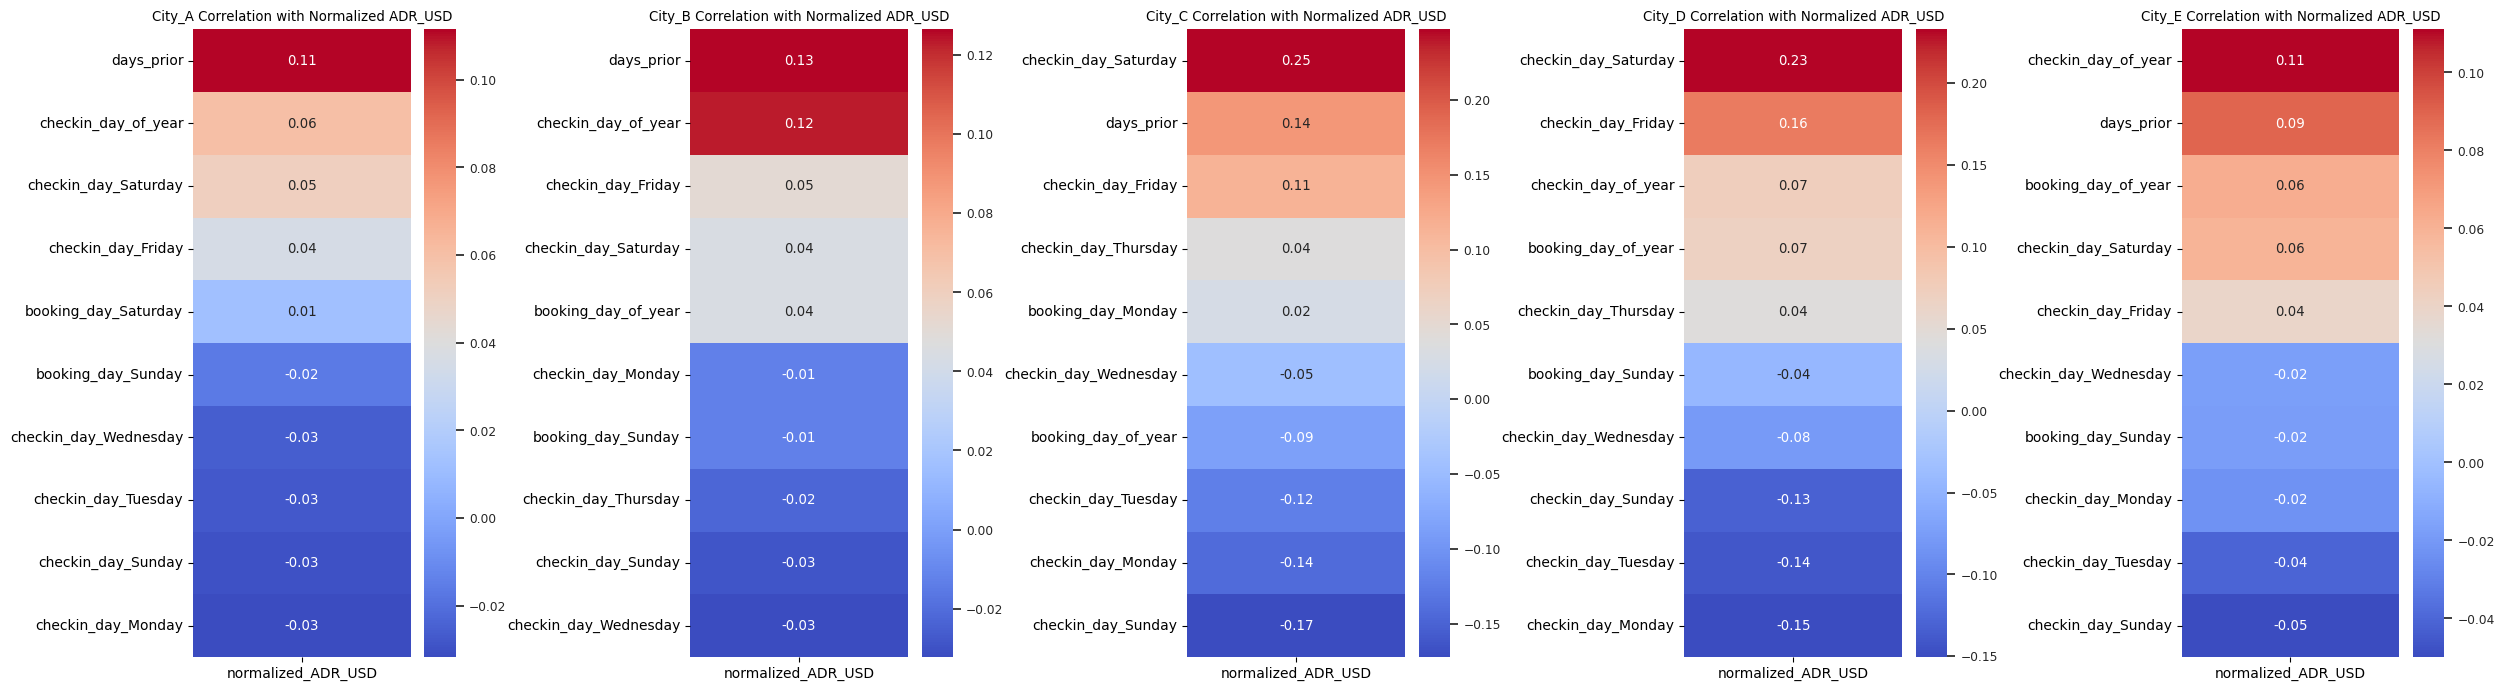

In [12]:
# Drop columns that are not needed for correlation analysis
pre_corr_df = encoded_df.drop(['#', 'ADR_USD_x', 'ADR_USD_y', 'hotel_id', 'city_id', 'booking_date', 'checkin_date', 'checkout_date'], axis=1)

# Create subplots for each city
fig, axes = plt.subplots(1, 5, figsize=(25, 7))

# Loop through each city and plot correlation heatmap
for idx, CITY in enumerate(CITIES):
    # Filter the data for the current city
    corr_df = pre_corr_df[pre_corr_df['Table Name'] == CITY].corr().sort_values('normalized_ADR_USD', ascending=False)
    
    # Extract correlations with the target column and select top and bottom correlated features
    target_corr_df = corr_df['normalized_ADR_USD'].drop(['normalized_ADR_USD'])
    target_corr_df.dropna(inplace=True)
    target_corr_df = pd.concat([target_corr_df[:5], target_corr_df[-5:]])
        
    ax = axes[idx]  # Get the specific subplot for the current city
    
    # Create a heatmap of correlations with the target column
    sns.set(font_scale=0.8)
    sns.set_style("white")
    sns.set_palette("PuBuGn_d")
    sns.heatmap(target_corr_df.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', ax=ax)
    
    ax.set_title(f'{CITY} Correlation with Normalized ADR_USD')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# -Prediction <a class="anchor"  id="chapter4"></a>

## -- Defining Evaluation Metrics <a class="anchor"  id="subchapter4.1"></a>

In [13]:
# Create an empty DataFrame with specified columns
comparison_col = ['Model', 'MSE', 'MAE', 'R2']
comparison_df = pd.DataFrame(columns=comparison_col)
display(comparison_df)

# Function to add model performance metrics to the comparison DataFrame
def add_to_comparison(comparison_df, model_name, mse, mae, r_squared):
    # Create a dictionary with model metrics
    df = {'Model': [model_name], 'MSE': [mse], 'MAE': [mae], 'R2': [r_squared]}
    
    # Concatenate the dictionary as a new row to the comparison DataFrame
    comparison_df = pd.concat([comparison_df, pd.DataFrame(data=df)])
    
    # Return the updated comparison DataFrame
    return comparison_df

,Model,MSE,MAE,R2


Analyzing the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²) involves understanding what each metric represents and interpreting their values in the context of your data and problem. Here's how you can analyze these metrics:

1. **Mean Squared Error (MSE)**:
   - Interpretation: MSE measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better predictive accuracy.
   - Analysis:
     - Compare MSE across models: Compare the MSE values of different models. A model with a lower MSE is generally preferred.
     - Relative scale: Keep in mind that MSE is dependent on the scale of the target variable. A small MSE might be good for a small-scale target variable, but the interpretation may differ for a larger-scale variable.

2. **Mean Absolute Error (MAE)**:
   - Interpretation: MAE measures the average absolute difference between the predicted values and the actual values. It is less sensitive to outliers compared to MSE.
   - Analysis:
     - Interpretability: MAE is easier to interpret as it represents the average error in the original units of the target variable.
     - Outliers: If your data has outliers that disproportionately affect the MSE, MAE might provide a more balanced view of the model's performance.

3. **R-squared (R²)**:
   - Interpretation: R² measures the proportion of the variance in the dependent variable that is explained by the independent variables. It ranges from 0 to 1, where a higher value indicates a better fit.
   - Analysis:
     - Model fit: A higher R² indicates that the model is capturing more of the variability in the data. However, a high R² doesn't necessarily mean that the model is valid; it could be overfitting.
     - Context: R² should be considered in context with the problem and the data. Some data might inherently have lower R² due to noise or external factors.

Additional Analysis Tips:
- Compare with baseline: Compare your model's MSE, MAE, and R² with a baseline model or naive approach to evaluate its improvement.
- Model complexity: Consider the trade-off between model complexity and performance metrics. More complex models might achieve lower training MSE but could overfit.
- Overfitting and underfitting: Analyze the metrics on both training and testing data to identify potential overfitting (low training MSE but high testing MSE) or underfitting (high training and testing MSE).
- Visualize: Plotting the predicted values against the actual values or creating residual plots can provide insights into the model's performance and identify patterns.

In summary, analyzing MSE, MAE, and R² involves interpreting their values, comparing models, considering the context of the problem and data, and using them in conjunction with visual analysis and other evaluation metrics. These metrics provide different perspectives on the model's accuracy, fit, and performance.

In [14]:
# Separate target variable and features
y = encoded_df['normalized_ADR_USD']  # Target variable (normalized_ADR_USD)
X = encoded_df.drop(['normalized_ADR_USD', 'booking_date', 'checkin_date', 'checkout_date', 'Table Name'], axis=1)  # Features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Uncomment the following line to print the shapes of the datasets
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## --Linear Regression <a class="anchor"  id="subchapter4.2"></a>

In [15]:
# Create a Linear Regression model
LR = LinearRegression()

# Train the Linear Regression model
LR.fit(X_train, y_train)

# Predict target variable using the trained model
y_pred = LR.predict(X_test)

# Calculate Mean Square Error (MSE), Mean Absolute Error (MAE), and R-squared
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'LR', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.033355,0.10135,0.695829


## --Decsion Tree <a class="anchor"  id="subchapter4.3"></a>

In [16]:
# Create a Decision Tree Regressor model
DT = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
DT.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = DT.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'DT', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.033355,0.101350,0.695829
0,DT,0.001572,0.009654,0.985662


## --Lasso Regresion <a class="anchor"  id="subchapter4.4"></a>

In [17]:
# Create a Lasso Regression model
alpha = 0.01  # Regularization parameter
lasso_model = Lasso(alpha=alpha)

# Fit the model to the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lasso_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Lasso', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.033355,0.101350,0.695829
0,DT,0.001572,0.009654,0.985662
0,Lasso,0.033399,0.100771,0.695427


The choice of `alpha` controls the strength of regularization. Higher values of `alpha` increase the amount of regularization applied.

## --Ridge Regression <a class="anchor"  id="subchapter4.5"></a>

In [18]:
# Create a Ridge Regression model
alpha = 1.0  # Regularization parameter
ridge_model = Ridge(alpha=alpha)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = ridge_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Ridge', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.033355,0.101350,0.695829
0,DT,0.001572,0.009654,0.985662
0,Lasso,0.033399,0.100771,0.695427
0,Ridge,0.033355,0.101347,0.695832


The choice of `alpha` controls the strength of regularization. Higher values of `alpha` increase the amount of regularization applied.

## --Elastic Net Regression <a class="anchor"  id="subchapter4.6"></a>

In [19]:
# Create an Elastic Net Regression model
alpha = 0.01  # Regularization parameter
l1_ratio = 0.5  # Mixing parameter between L1 and L2 regularization
elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

# Fit the model to the training data
elastic_net_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = elastic_net_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

# Add model metrics to the comparison DataFrame
comparison_df = add_to_comparison(comparison_df, 'Elastic Net', mse, mae, r_squared)

# Display the updated comparison DataFrame
display(comparison_df)

,Model,MSE,MAE,R2
0,LR,0.033355,0.101350,0.695829
0,DT,0.001572,0.009654,0.985662
0,Lasso,0.033399,0.100771,0.695427
0,Ridge,0.033355,0.101347,0.695832
0,Elastic Net,0.033395,0.100797,0.695462


# Conclusion <a class="anchor"  id="chapter5"></a>

A model with low Mean Squared Error (MSE), low Mean Absolute Error (MAE), and high R-squared (R2) is considered to be a good-performing model for regression analysis. Here's an explanation of each of these evaluation metrics and how they contribute to the assessment of the model's performance:

1. **Mean Squared Error (MSE):**
   MSE is a measure of the average squared difference between the predicted values and the actual target values. Lower MSE values indicate that the model's predictions are closer to the actual values. In other words, a low MSE means that the model's errors are relatively small and consistent. It is calculated as the average of the squared differences between predicted and actual values.

2. **Mean Absolute Error (MAE):**
   MAE is a measure of the average absolute difference between the predicted values and the actual target values. Similar to MSE, lower MAE values indicate that the model's predictions are closer to the actual values. It measures the average magnitude of errors without considering their direction.

3. **R-squared (R2) or Coefficient of Determination:**
   R-squared measures the proportion of the variance in the dependent variable (target) that is explained by the independent variables (features) in the model. It ranges from 0 to 1, with a higher value indicating a better fit of the model to the data. A high R2 indicates that a large portion of the variability in the target variable is explained by the model's predictions.

When you have a model with low MSE and MAE, it means that the model's predictions are accurate and close to the actual values. A high R2 indicates that the model is capturing a significant amount of the variability in the target variable, which suggests that the model's predictions align well with the underlying patterns in the data.

In summary, a model with low MSE, low MAE, and high R2 is a model that makes accurate predictions, closely follows the actual values, and effectively explains the variability in the target variable. Such a model is generally considered to be a good choice for regression tasks and is likely to provide reliable predictions on new, unseen data.

**Decision Tree** has the lowest MSE, lowest MAE and highest R2.